In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import seaborn as sns
sns.set()

In [2]:
ls ../data

data3a.csv  data_R.csv


In [3]:
df = pd.read_csv('../data/data3a.csv')

In [4]:
df.head()

,y,x,f
0,6,8.31,C
1,6,9.44,C
2,6,9.50,C
3,12,9.07,C
4,10,10.16,C


In [5]:
df.describe(include=['O'])

,f
count,100
unique,2
top,C
freq,50


In [6]:
df.describe(include='all')

,y,x,f
count,100.000000,100.000000,100
unique,NaN,NaN,2
top,NaN,NaN,C
freq,NaN,NaN,50
mean,7.830000,10.089100,NaN
std,2.624881,1.008049,NaN
min,2.000000,7.190000,NaN
25%,6.000000,9.427500,NaN
50%,8.000000,10.155000,NaN
75%,10.000000,10.685000,NaN


In [7]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
y    100 non-null int64
x    100 non-null float64
f    100 non-null object
dtypes: float64(1), int64(1), object(1)
memory usage: 2.4+ KB


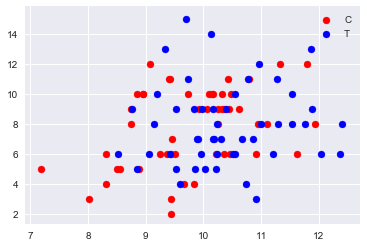

In [8]:
colors = ['red', 'blue']
factors = ['C', 'T']
for factor, color in zip(factors, colors):
    plt.scatter(df[df['f']==factor]['x'], df[df['f']==factor]['y'], c=color, label=factor)
    plt.legend()
plt.show()

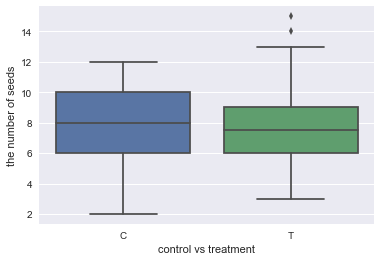

In [11]:
sns.boxplot(x="f", y="y", data=df)
plt.ylabel("the number of seeds")
plt.xlabel("control vs treatment")
plt.show()

In [15]:
def expo_link(beta_1, beta_2):
    """show the exponential function for different beta"""
    x = np.arange(-5, 6)
    lambda_i = np.exp(beta_1 + beta_2 * x)
    plt.plot(x, lambda_i, label=r'$\beta_1={0}, \beta_2={1}$'.format(beta_1, beta_2))
    plt.ylim([0, 3.0])
    plt.xlabel('X')
    plt.ylabel(r'exp($\beta_1 + \beta_2*x_i$)')
    plt.vlines(0,ymin=0, ymax=3.0, linestyles='dashed')
    plt.title(r"Exponential function: exp($\beta_1 + \beta_2*x_i$)")
    plt.legend(loc='upper right')

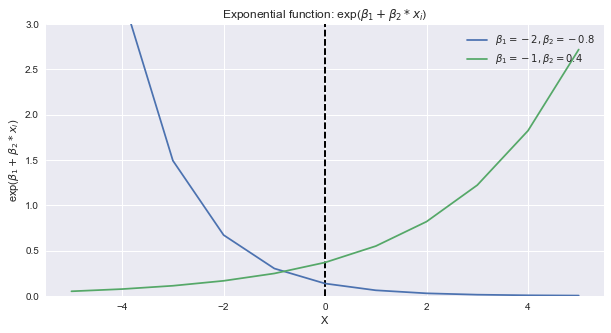

In [16]:
betas = [[-2, -0.8], [-1, 0.4]]
plt.figure(figsize=(10, 5))
for beta in betas:
    expo_link(*beta)

In [21]:
print(np.log(0.00001))

-11.512925465


In [22]:
import statsmodels.api as sm

/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [27]:
data_exog = sm.add_constant(df['x'])
poisson_model = sm.GLM(df['y'], data_exog, family=sm.families.Poisson())

In [28]:
poisson_results = poisson_model.fit()

In [52]:
poisson_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -235.39
Date:                Tue, 02 Oct 2018   Deviance:                       84.993
Time:                        00:46:42   Pearson chi2:                     83.8
No. Iterations:                     4                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2917      0.364      3.552      0.000       0.579       2.005
x              0.0757      0.036      2.125      0.034       0.006       0.145
==============================================================================
"""

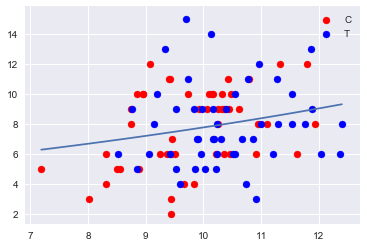

In [41]:
colors = ['red', 'blue']
factors = ['C', 'T']
for factor, color in zip(factors, colors):
    plt.scatter(df[df['f']==factor]['x'], df[df['f']==factor]['y'], c=color, label=factor)
    plt.legend()
xx = np.linspace(np.min(df['x']), np.max(df['x']),100)
plt.plot(xx, np.exp(1.2917 + 0.0757*xx))
plt.show()

In [45]:
print(np.unique(df['f']))

['C' 'T']


In [60]:
f_dummy = df['f'].map({'C':0, 'T':1})

In [56]:
data_exog_f = sm.add_constant(f_dummy)
poisson_model_f = sm.GLM(df['y'], data_exog_f, family=sm.families.Poisson())

In [61]:
poisson_f_results = poisson_model_f.fit()

In [62]:
poisson_f_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -237.63
Date:                Tue, 02 Oct 2018   Deviance:                       89.475
Time:                        00:54:41   Pearson chi2:                     87.1
No. Iterations:                     4                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0516      0.051     40.463      0.000       1.952       2.151
f              0.0128      0.071      0.179      0.858      -0.127       0.153
==============================================================================
"""

In [70]:
df_tmp = df['x'].to_frame()
df_tmp['f'] = f_dummy
df_tmp['y'] = df['y']
df_tmp.head()

,x,f,y
0,8.31,0,6
1,9.44,0,6
2,9.50,0,6
3,9.07,0,12
4,10.16,0,10


In [74]:
import statsmodels.formula.api as smf
poisson_all = smf.glm(formula='y ~ x + f', data=df_tmp, family=sm.families.Poisson(sm.families.links.log))

In [75]:
poisson_all_results = poisson_all.fit()

In [76]:
poisson_all_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       97
Model Family:                 Poisson   Df Model:                            2
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -235.29
Date:                Tue, 02 Oct 2018   Deviance:                       84.808
Time:                        01:09:55   Pearson chi2:                     83.8
No. Iterations:                     4                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2631      0.370      3.417      0.001       0.539       1.988
x              0.0801      0.037      2.162      0.031       0.007       0.153
f             -0.0320      0.074     -0.430      0.667      -0.178       0.114
==============================================================================
"""

In [81]:
np.array([0]* 10)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

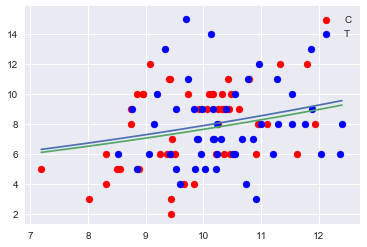

In [83]:
colors = ['red', 'blue']
factors = ['C', 'T']
for factor, color in zip(factors, colors):
    plt.scatter(df[df['f']==factor]['x'], df[df['f']==factor]['y'], c=color, label=factor)
    plt.legend()
xx = np.linspace(np.min(df['x']), np.max(df['x']),100)
ff = [np.array([0] * 100), np.array([1] * 100)]
for i in range(2):
    plt.plot(xx, np.exp(1.2631 + 0.0801*xx-0.0320*ff[i]))
plt.show()

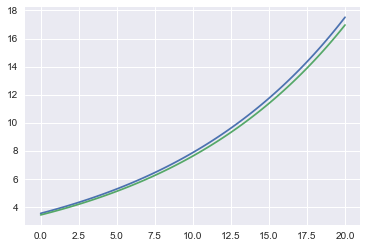

In [92]:
xx = np.linspace(0, 20, 100)
ff = [np.array([0] * 100), np.array([1] * 100)]
for i in range(2):
    plt.plot(xx, np.exp(1.2631 + 0.08*xx-0.0320*ff[i]))
plt.show()

In [94]:
poisson_idt = smf.glm(formula='y ~ x + f', data=df_tmp, family=sm.families.Poisson(sm.families.links.identity))

/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/statsmodels/genmod/generalized_linear_model.py:244: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  DomainWarning)


In [95]:
poisson_idt_results = poisson_idt.fit()

In [96]:
poisson_idt_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       97
Model Family:                 Poisson   Df Model:                            2
Link Function:               identity   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -235.16
Date:                Tue, 02 Oct 2018   Deviance:                       84.538
Time:                        01:19:59   Pearson chi2:                     83.6
No. Iterations:                     5                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2671      2.843      0.446      0.656      -4.306       6.840
x              0.6606      0.290      2.281      0.023       0.093       1.228
f             -0.2048      0.582     -0.352      0.725      -1.346       0.936
==============================================================================
"""

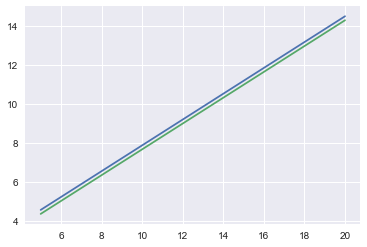

In [100]:
xx = np.linspace(5, 20, 100)
ff = [np.array([0] * 100), np.array([1] * 100)]
for i in range(2):
    plt.plot(xx, 1.2671 + 0.6606*xx-0.2048*ff[i])
plt.show()